### Evolution of Value-Embedding Gates

All checkpoints are taken from the same run.

In [3]:
import re
import torch
import numpy as np
from pathlib import Path
from tools.checkpoint import model_from_checkpoint

directory = Path("/Users/jonathanmiddleton/models/checkpoints/milli-dclm-base/20251205")

def tokens_from_name(path: Path) -> int:
    m = re.search(r"tokens(\d+)", path.name)
    if not m:
        raise ValueError(f"Could not find 'tokens...' in filename: {path.name}")
    return int(m.group(1))

pt_files = sorted(directory.glob("*.pt"), key=tokens_from_name)

layers: dict[int, list[float]] = {}
token_counts: list[int] = []

with torch.no_grad():
    for f in pt_files:
        model = model_from_checkpoint(f, device='cpu')[0]
        token_counts.append(tokens_from_name(f))

        for b in model.blocks:
            if (attn := b.attn) is not None and (g := attn.g_ve) is not None:
                g_s = torch.sigmoid(g).item()
                layers.setdefault(b.layer_idx, []).append(g_s)

tokens_b = np.array(token_counts, dtype=float) / 1e9
layer_ids = sorted(layers.keys())

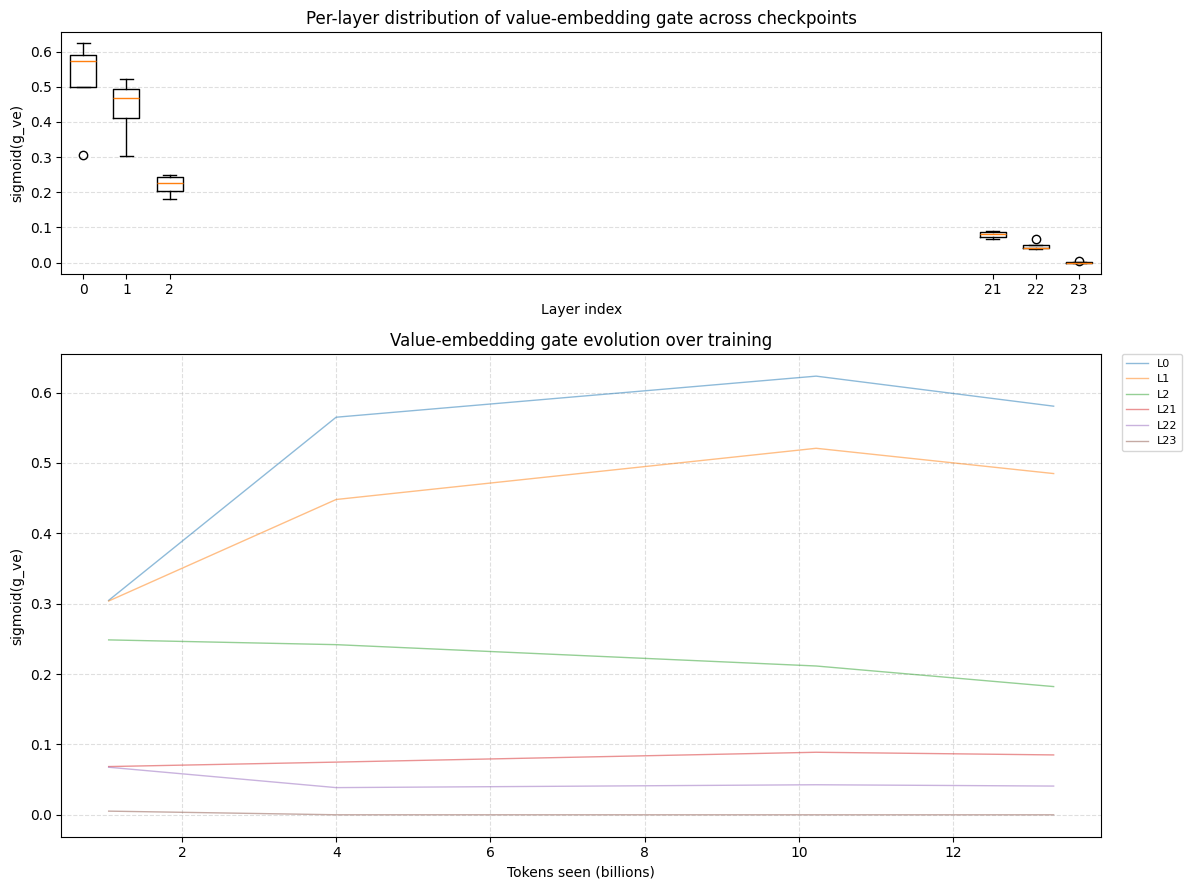

In [4]:
import matplotlib.pyplot as plt

layer_ids = sorted(layers.keys())
data = [layers[i] for i in layer_ids]

fig, (ax_box, ax_ts) = plt.subplots(
    2, 1, figsize=(12, 9), gridspec_kw={"height_ratios": [1, 2]}
)

ax_box.boxplot(data, positions=layer_ids, widths=0.6)
ax_box.set_xlabel("Layer index")
ax_box.set_ylabel("sigmoid(g_ve)")
ax_box.set_title("Per-layer distribution of value-embedding gate across checkpoints")
ax_box.grid(True, axis='y', linestyle='--', alpha=0.4)

for i in layer_ids:
    ax_ts.plot(tokens_b, layers[i], alpha=0.5, linewidth=1.0, label=f"L{i}")

ax_ts.set_xlabel("Tokens seen (billions)")
ax_ts.set_ylabel("sigmoid(g_ve)")
ax_ts.set_title("Value-embedding gate evolution over training")
ax_ts.grid(True, linestyle='--', alpha=0.4)

ax_ts.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0,
    fontsize=8,
    ncol=1,
)

plt.tight_layout()
plt.show()